# RAPIDS & Scanpy Single-Cell RNA-seq Workflow

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2 and TMPRSS2 genes. See the README for instructions to download this dataset.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')

We use the RAPIDS memory manager on the GPU to control how memory is allocated.

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

We recommend saving count matrices in the sparse .h5ad format as it is much faster to load than a dense CSV file. To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
input_file = "./krasnow_hlca_10x_UMIs.sparse.h5ad"

## Set parameters

In [4]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [5]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [6]:
data_load_start = time.time()

In [7]:
adata = sc.read(input_file)
adata = adata.T

In [8]:
adata.shape

(65662, 26485)

We maintain the index of unique cells and genes in our dataset:

In [9]:
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)

In [10]:
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

Verify the shape of the resulting sparse matrix:

In [11]:
sparse_gpu_array.shape

(65662, 26485)

And the number of non-zero values in the matrix:

In [12]:
sparse_gpu_array.nnz

126510394

In [13]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 6.393196105957031


## Preprocessing

In [14]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [15]:
%%time
filtered = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

Running 7 batches
CPU times: user 524 ms, sys: 685 ms, total: 1.21 s
Wall time: 1.24 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [16]:
%%time
filtered, genes = rapids_scanpy_funcs.filter_genes(filtered, genes, min_cells=1)

CPU times: user 695 ms, sys: 217 ms, total: 911 ms
Wall time: 909 ms


The size of our count matrix is now reduced.

In [17]:
filtered.shape

(65462, 22058)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [18]:
%%time
normalized = rapids_scanpy_funcs.normalize_total(filtered, target_sum=1e4)

CPU times: user 1.59 s, sys: 870 ms, total: 2.46 s
Wall time: 2.46 s


Next, we log transform the count matrix.

In [19]:
%%time
normalized = normalized.log1p()

CPU times: user 204 ms, sys: 36.7 ms, total: 241 ms
Wall time: 266 ms


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [20]:
%%time
adata = anndata.AnnData(normalized.get())
adata.var_names = genes.to_pandas()

CPU times: user 300 ms, sys: 164 ms, total: 464 ms
Wall time: 463 ms


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [21]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.69 s, sys: 42 ms, total: 1.73 s
Wall time: 1.96 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

Before regression, we save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of an epithelial marker gene (EPCAM).

In [22]:
tmp_norm = normalized.tocsc()
ACE2_raw = tmp_norm[:, genes[genes == "ACE2"].index[0]].todense().ravel()
TMPRSS2_raw = tmp_norm[:, genes[genes == "TMPRSS2"].index[0]].todense().ravel()
EPCAM_raw = tmp_norm[:, genes[genes == "EPCAM"].index[0]].todense().ravel()

del tmp_norm

In [23]:
genes = adata.var_names
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [24]:
filtered = adata.X

We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [25]:
n_counts = filtered.sum(axis=1)
percent_ribo = (filtered[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

And perform regression:

In [26]:
normalized = cp.array(adata.X.todense(), order="F")
normalized = rapids_scanpy_funcs.regress_out(normalized, n_counts, percent_ribo)

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [27]:
normalized = rapids_scanpy_funcs.scale(normalized, max_value=10)

In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 49.01011776924133


## Cluster & Visualize

In [29]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [30]:
var_names = adata.var_names
adata = anndata.AnnData(normalized.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw.get()
adata.obs["EPCAM_raw"] = EPCAM_raw.get()

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [31]:
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)

In [32]:
adata.obsm["X_pca"].shape

(65462, 50)

### TSNE + K-means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [33]:
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

We cluster the cells using k-means on the principal components. For example purposes, we set k=20.

In [34]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


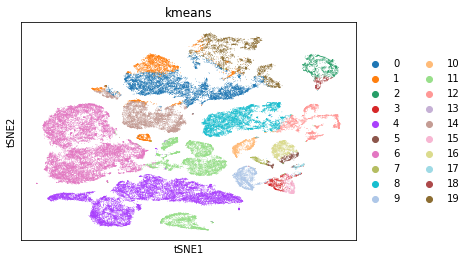

In [35]:
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

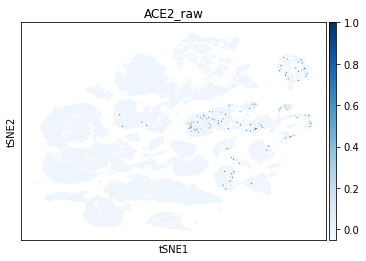

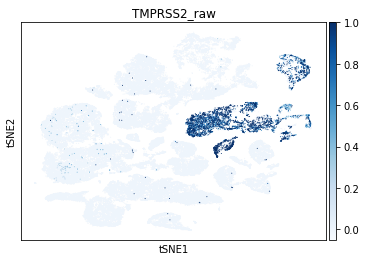

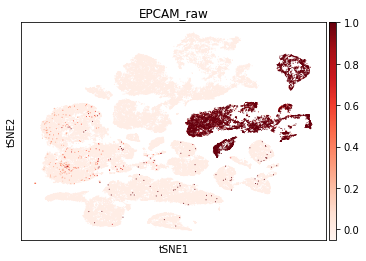

In [36]:
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [37]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

The UMAP function from Rapids is also integrated into Scanpy.

In [38]:
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [39]:
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

/home/brad/anaconda3/envs/cugraph_dev/lib/python3.7/site-packages/cugraph-0.15.0a0+203.g45b02a24.dirty-py3.7-linux-x86_64.egg/cugraph/structure/graph.py:333: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

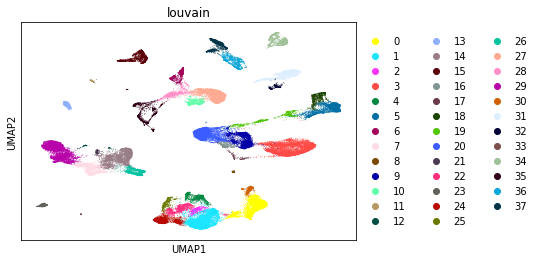

In [40]:
sc.pl.umap(adata, color=["louvain"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

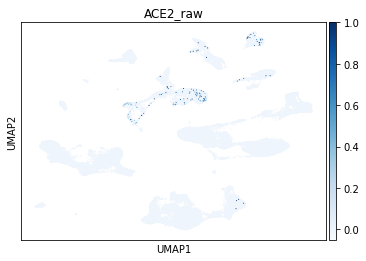

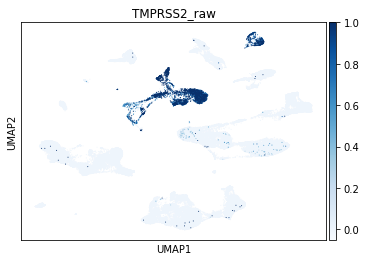

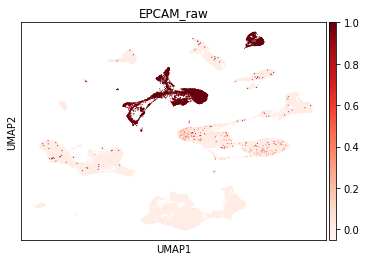

In [41]:
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [42]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 17.13982605934143


## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [43]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    normalized, 
    cluster_labels, 
    var_names, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

Ranking took (GPU): 6.513525724411011
Preparing output np.rec.fromarrays took (CPU): 0.0026662349700927734
Note: This operation will be accelerated in a future version


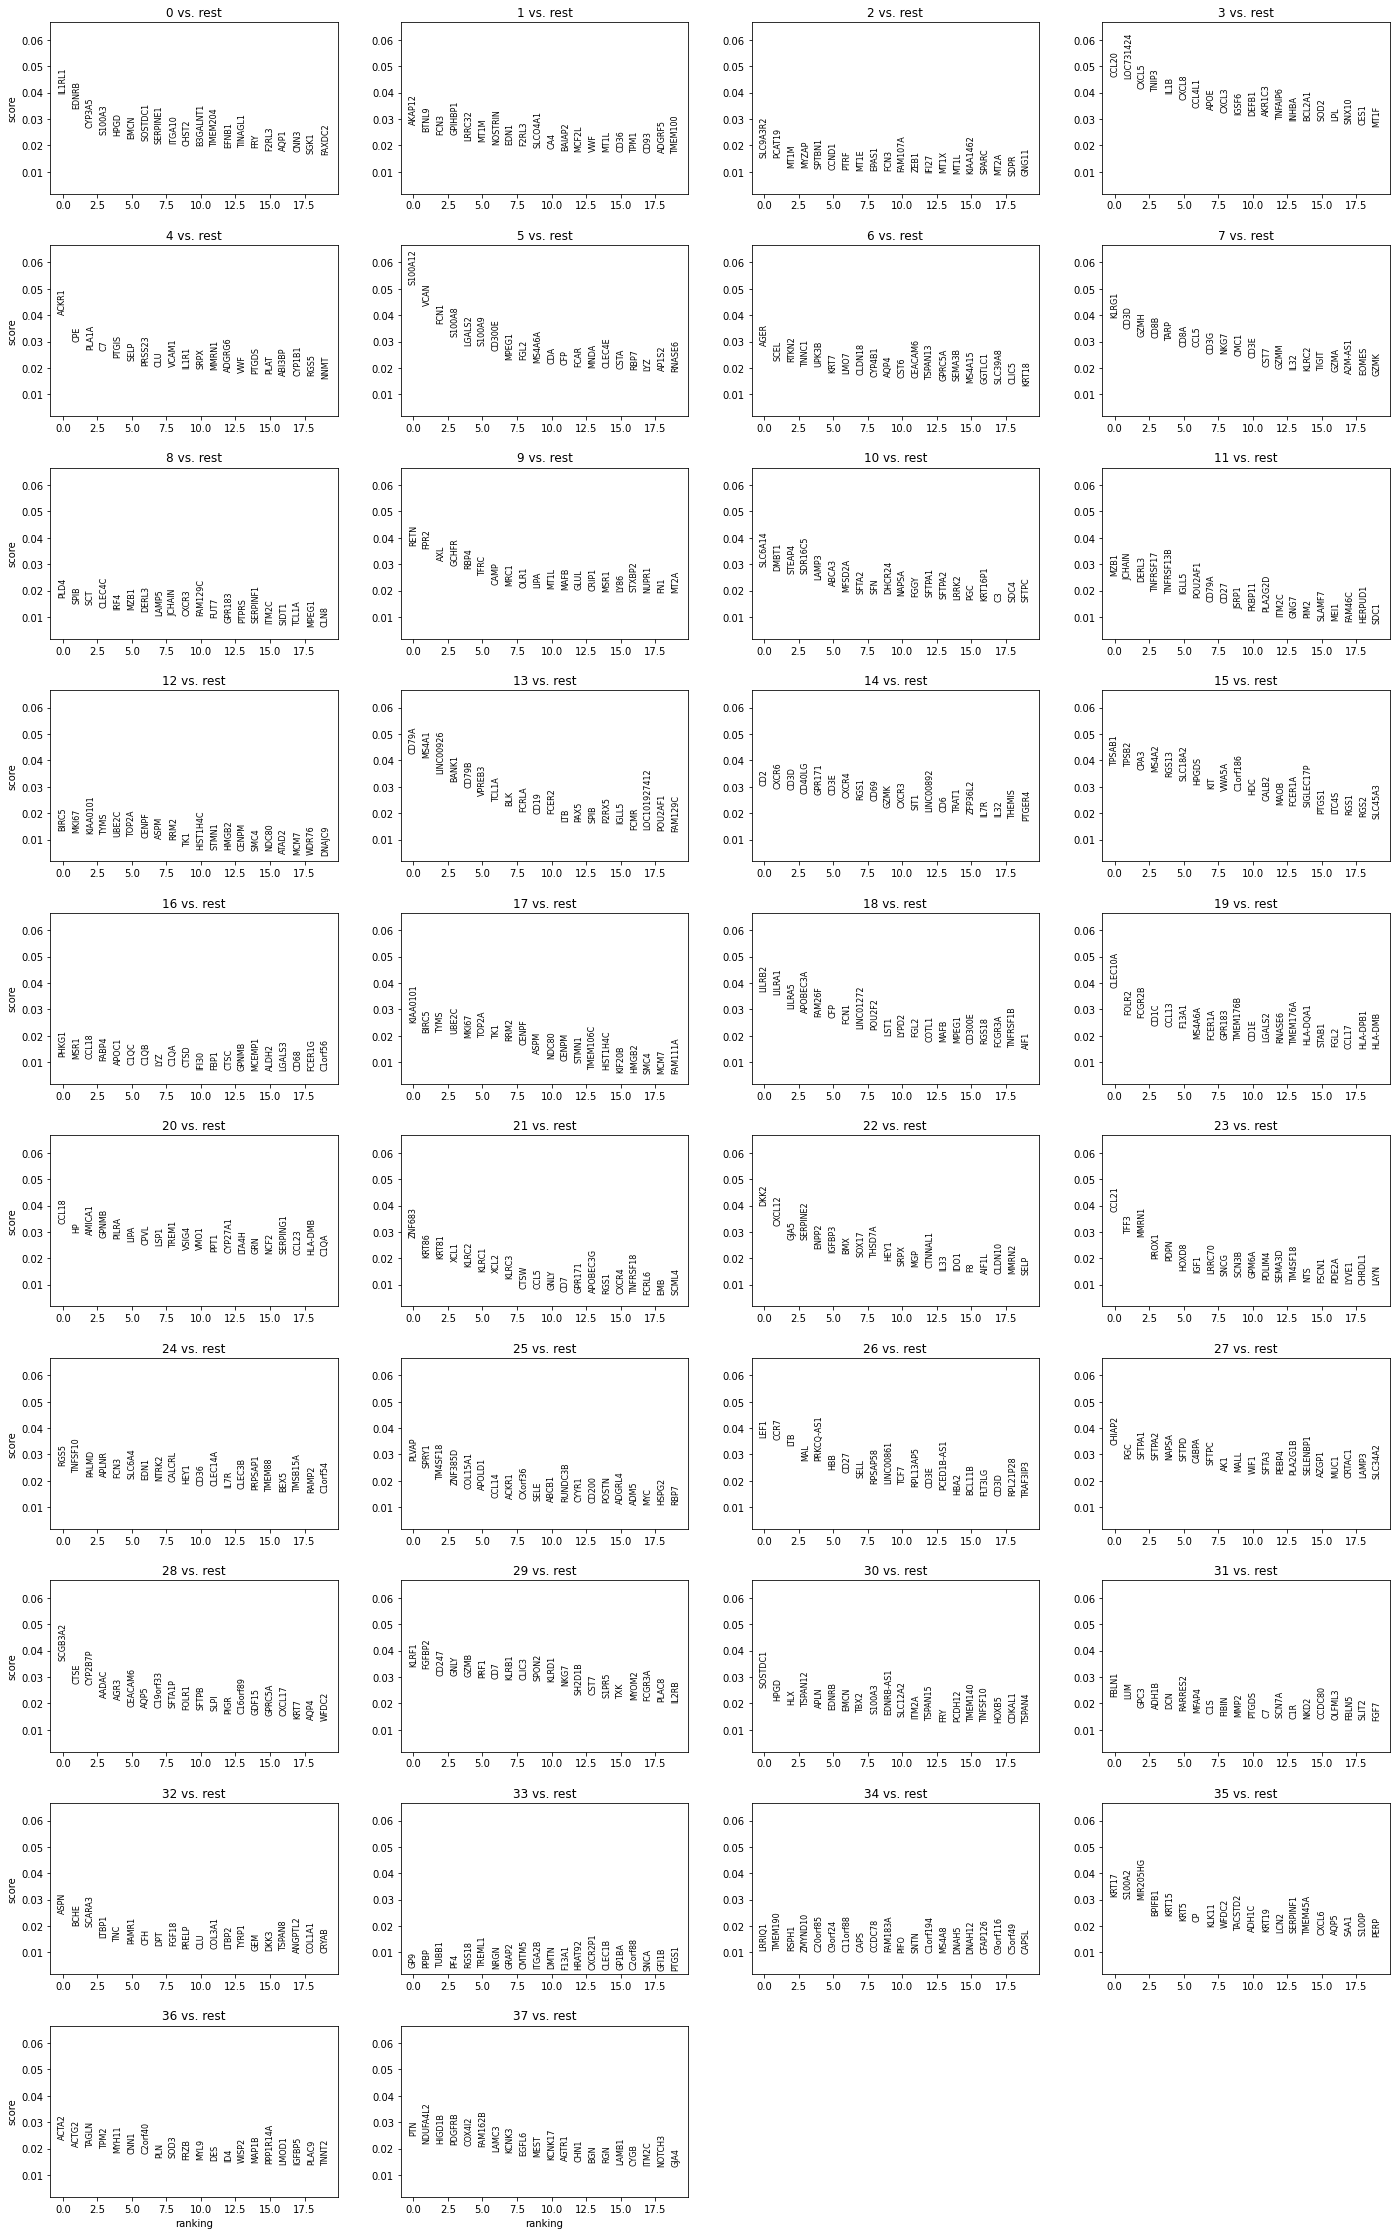

In [45]:
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [46]:
reanalysis_start = time.time()

In [47]:
epcam_cells = EPCAM_raw > 0.0

normalized_epcam_cells = normalized[epcam_cells]
ACE2_raw_epcam = ACE2_raw[epcam_cells]
TMPRSS2_raw_epcam = TMPRSS2_raw[epcam_cells]

var_names = adata.var_names
adata = anndata.AnnData(normalized_epcam_cells.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw_epcam.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw_epcam.get()
print(adata.X.shape)

(7958, 5000)


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

/home/brad/anaconda3/envs/cugraph_dev/lib/python3.7/site-packages/cugraph-0.15.0a0+203.g45b02a24.dirty-py3.7-linux-x86_64.egg/cugraph/structure/graph.py:333: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


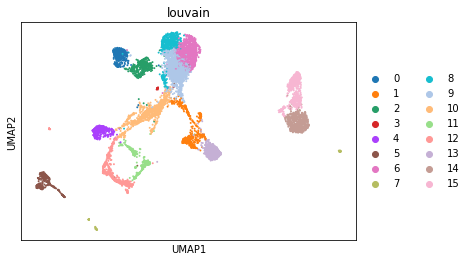

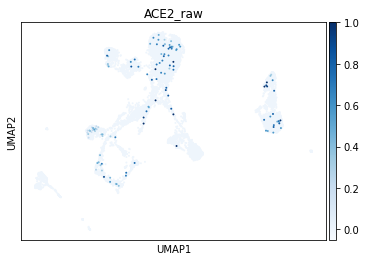

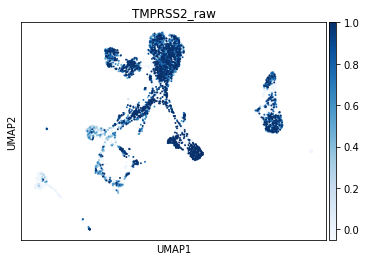

In [48]:
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids', resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [49]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 3.689302682876587


In [50]:
print("Full time: %s" % (time.time() - start))

Full time: 89.58523154258728
